# Scene Model Training Notebook

This notebook provides an interactive environment for training Scene Models on the FindingEmo dataset.

## Features
- V-A regression with WMSE loss
- Emo8 classification with UCE loss
- Multiple backbone support (DINOv3, CLIP, ImageNet)
- Automatic learning rate detection
- Real-time training visualization
- Comprehensive evaluation and plotting

## Quick Start
1. Set your dataset path in the configuration section
2. Choose your model configuration
3. Run training cells sequentially
4. Analyze results in the evaluation section


## 1. Setup and Imports


In [1]:
import os
import sys
from pathlib import Path
import warnings
import traceback
from datetime import datetime

# Setup project paths
NOTEBOOK_DIR = Path(os.getcwd())
PROJECT_ROOT = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == 'notebooks' else NOTEBOOK_DIR
SRC_PATH = PROJECT_ROOT / "src"

# Add paths to sys.path
for path in [str(PROJECT_ROOT), str(SRC_PATH)]:
    if path not in sys.path:
        sys.path.insert(0, path)

print(f"📂 Project Root: {PROJECT_ROOT}")
print(f"📂 Source Path: {SRC_PATH}")
print(f"✅ Paths configured")

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchvision")
warnings.filterwarnings("ignore", category=FutureWarning)


📂 Project Root: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO
📂 Source Path: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/src
✅ Paths configured


In [2]:
# Core imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging

# Project imports
from src.utils.config import create_arg_parser, load_config
from src.utils.device import DeviceManager
from src.utils.logging_utils import setup_logging
from src.utils.auto_lr import auto_detect_learning_rate
from src.data.datasets import create_dataset, create_dataloader
from src.data.transforms import create_transforms_from_config
from src.models.va_models import create_va_model
from src.training.losses import create_loss_function
from src.utils.metrics import evaluate_scene_model_predictions
from src.evaluation.evaluator import VAEvaluator

# Setup matplotlib for notebook
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful")


✅ All imports successful


## 2. Configuration

Choose your training configuration. You can either:
1. Use a predefined config file
2. Create a custom configuration inline


In [ ]:
# === CONFIGURATION SECTION ===
# Modify these variables according to your setup

# Dataset path - REQUIRED
FINDINGEMO_PATH = "/Users/kevinmanuel/Documents/NUS-Project-Sem2/FindingEmo"  # UPDATE THIS PATH
MODEL_NAME = "scene_clip_vit_b32_frozen_notebook"

# Choose configuration approach
USE_CONFIG_FILE = False  # Set to False to use inline configuration

# Option 1: Use existing config file (used when USE_CONFIG_FILE = True)
CONFIG_FILE = PROJECT_ROOT / "configs/scene_models/scene_model_clip_vit_b32_frozen_auto_lr_config.yaml"

# Option 2: Inline configuration (used when USE_CONFIG_FILE = False)
# Replace the INLINE_CONFIG with this complete version:
INLINE_CONFIG = {
    "model": {
        "model_name": MODEL_NAME,
        "backbone_type": "clip",
        "clip_model_name": "ViT-B/32",
        "feature_dim": 512,
        "freeze_backbone": True,
        "head_config": {
            "hidden_dims": [256, 128],
            "dropout_rate": 0.3,
            "batch_norm": True,
            "activation": "relu"
        },
        # Output configuration
        "va_output_range": [-1, 1],                  # V-A range as per research
        "va_activation": "tanh",                     # Tanh for bounded output
        "emo8_classes": 8,                           # 8 Plutchik emotions
        "freeze_backbone": True,                     # Freeze CLIP parameters
        "unfreeze_epochs": None                     # Keep frozen throughout training
    },
    "training": {
        "learning_rate": "auto", # use auto to detect optimal LR using lr_finder
        "batch_size": 32,
        "num_epochs": 50,
        "optimizer": "adamw",
        "scheduler": "cosine",
        "optimizer_config": {
            "weight_decay": 0.01,
            "betas": [0.9, 0.999]
        },
        "scheduler_config": {
            "step_size": 10,
            "gamma": 0.1,
            "min_lr": 1e-6
        },
        "loss": {
            "type": "combined",
            "va_loss_weight": 1.0,
            "emo8_loss_weight": 0.1,
            "use_focal_loss": False
        },
        "early_stopping": {
            "enabled": True,
            "patience": 10,
            "monitor_metric": "va_mae_avg",
            "mode": "min"
        }
    },
    "data": {
        "dataset_type": "findingemo",
        "findingemo_path": FINDINGEMO_PATH,

        "train_split": 0.8,
        "val_split": 0.1,
        "test_split": 0.1,

        "stratify_on": ["emo8", "valence_bin", "arousal_bin"],
        "save_split_indices": True,
        "load_split_indices": True,

        # CLIP-specific preprocessing: CLIP ViT-B/32 expects 224x224 square images
        "image_size": 224,                  # CLIP ViT-B/32 input size
        "keep_aspect_ratio": False,         # CLIP expects square images
        "use_backbone_specific": True,      # Use CLIP normalization

        # Augmentation (conservative for CLIP)
        "augmentation": {
            "enabled": True,
            "horizontal_flip": 0.5,
            "rotation": 15,                 # Less rotation for CLIP
            "crop_scale": [0.85, 1.0],      # Less aggressive cropping
            "perspective_transform": 0.1,   # Minimal perspective for CLIP
            "color_jitter": {
                "brightness": 0.25,         # More conservative color jitter
                "contrast": 0.25,
                "saturation": 0.15,
                "hue": 0.05
            },
            "gaussian_blur": 0.05 # Minimal blur for CLIP
        }
    }
}

# Validate paths
if not Path(FINDINGEMO_PATH).exists():
    print(f"❌ Error: FindingEmo path does not exist: {FINDINGEMO_PATH}")
    print("Please update FINDINGEMO_PATH variable above")
else:
    print(f"✅ FindingEmo dataset found at: {FINDINGEMO_PATH}")

if USE_CONFIG_FILE and not CONFIG_FILE.exists():
    print(f"❌ Warning: Config file not found: {CONFIG_FILE}")
    print("Will use inline configuration instead")
    USE_CONFIG_FILE = False

print(f"📋 Configuration mode: {'File-based' if USE_CONFIG_FILE else 'Inline'}")


✅ FindingEmo dataset found at: /Users/kevinmanuel/Documents/NUS-Project-Sem2/FindingEmo
📋 Configuration mode: Inline


## 3. Load Configuration and Setup


In [4]:
# Load configuration
if USE_CONFIG_FILE:
    # Create minimal args for config loading
    class Args:
        def __init__(self):
            self.config = str(CONFIG_FILE)
            # Override dataset path
            setattr(self, 'data.findingemo_path', FINDINGEMO_PATH)
    
    args = Args()
    config = load_config(CONFIG_FILE, args)
    print(f"✅ Loaded config from: {CONFIG_FILE}")
else:
    # Use inline configuration
    from src.utils.config import DictConfig
    
    # Add default values for missing sections
    default_config = {
        "hardware": {
            "device": "auto",
            "mixed_precision": True,
            "num_workers": 4,
            "pin_memory": True
        },
        "reproducibility": {
            "seed": 42
        },
        "logging": {
            "log_every_n_steps": 50,
            "experiment_name": f"notebook_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        },
        "checkpointing": {
            "save_dir": str(PROJECT_ROOT / "checkpoints" / MODEL_NAME),
            "save_every_n_epochs": 5,
            "save_best_only": False,
            "monitor_metric": "va_mae_avg",
            "save_optimizer": True,
            "save_scheduler": True
        },
        "evaluation": {
            "metrics": ["mae", "mse", "rmse", "ccc", "pearson", "spearman"],
            "compute_per_quadrant": True,
            "save_predictions": True,
            "emo8_metrics": ["weighted_f1", "macro_f1", "accuracy"]
        }
    }
    
    # Merge configurations
    full_config = {**default_config, **INLINE_CONFIG}
    config = DictConfig(full_config)
    print("✅ Using inline configuration")

# Display key configuration
print("\n📋 Key Configuration:")
print(f"   Model: {config.model.model_name}")
print(f"   Backbone: {config.model.backbone_type}")
print(f"   Learning Rate: {config.training.learning_rate}")
print(f"   Batch Size: {config.training.batch_size}")
print(f"   Epochs: {config.training.num_epochs}")
print(f"   Dataset: {config.data.dataset_type}")


✅ Using inline configuration

📋 Key Configuration:
   Model: scene_clip_vit_b32_frozen_notebook
   Backbone: clip
   Learning Rate: auto
   Batch Size: 32
   Epochs: 50
   Dataset: findingemo


In [5]:
# Setup reproducibility
torch.manual_seed(config.reproducibility.seed)
torch.cuda.manual_seed_all(config.reproducibility.seed)
np.random.seed(config.reproducibility.seed)

# Setup device management
device_manager = DeviceManager(
    device=config.hardware.device,
    mixed_precision=config.hardware.mixed_precision,
    verbose=True
)

# Setup logging (simplified for notebook)
logging.basicConfig(level=logging.WARNING, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

print(f"✅ Setup complete - Using device: {device_manager.device}")



🔧 Device Manager Information
Selected Device: mps
Mixed Precision: False
Apple Silicon: MPS backend available
PyTorch Version: 2.8.0
✅ Setup complete - Using device: mps


## 4. Auto Learning Rate Detection (Optional)


In [6]:
from scripts.train_scene_model import SceneModelTrainer

# Auto-detect learning rate if needed
if (hasattr(config.training, 'learning_rate') and 
    (config.training.learning_rate == 'auto' or str(config.training.learning_rate).lower() == 'auto')):
    
    print("🤖 Auto-detecting optimal learning rate...")
    
    # Temporarily set a default learning rate for trainer creation
    original_lr = config.training.learning_rate
    config.training.learning_rate = 1e-4  # Default for auto detection

    # Create temporary trainer to get data loaders
    temp_trainer = SceneModelTrainer(config, device_manager, logger)

    # Run auto LR detection
    optimal_lr, lr_info = auto_detect_learning_rate(
        model=temp_trainer.model,
        backbone_type=getattr(config.model, 'backbone_type', 'clip'),
        freeze_backbone=getattr(config.model, 'freeze_backbone', True),
        batch_size=config.training.batch_size,
        device=device_manager.device,
        train_loader=temp_trainer.train_loader,
        use_lr_finder=False,
        num_epochs=getattr(config.training, 'num_epochs', 50)
    )
    
    # Update learning rate
    config.training.learning_rate = optimal_lr

    # Clean up temporary trainer
    del temp_trainer
    
    ## Recreate optimizer with new learning rate
    #for param_group in trainer.optimizer.param_groups:
    #    param_group['lr'] = optimal_lr
    
    print(f"✅ Auto-detected learning rate: {optimal_lr:.2e}")
    print(f"📊 Detection method: {lr_info['method']}")
    print(f"🎯 Backbone: {lr_info['backbone_type']} ({'frozen' if lr_info['frozen'] else 'unfrozen'})")
    print(f"📈 Empirical range: {lr_info['empirical_range'][0]:.2e} - {lr_info['empirical_range'][1]:.2e}")

    # Optionally update scheduler config
    if 'schedule_config' in lr_info and hasattr(config.training, 'scheduler'):
        schedule_config = lr_info['schedule_config']
        if hasattr(config.training, 'warmup_epochs'):
            config.training.warmup_epochs = schedule_config['warmup_epochs']
        if hasattr(config.training, 'min_lr'):
            config.training.min_lr = schedule_config['min_lr']
        
        print(f"📈 Updated scheduler config:")
        print(f"   Warmup epochs: {schedule_config['warmup_epochs']}")
        print(f"   Min LR: {schedule_config['min_lr']:.2e}")
else:
    print(f"📋 Using configured learning rate: {config.training.learning_rate}")


🤖 Auto-detecting optimal learning rate...


✅ Auto-detected learning rate: 1.00e-04
📊 Detection method: empirical
🎯 Backbone: clip (frozen)
📈 Empirical range: 5.00e-05 - 5.00e-04
📈 Updated scheduler config:
   Warmup epochs: 2
   Min LR: 1.00e-06


## 5. Notebook Scene Model Trainer

This is a notebook-adapted version of the SceneModelTrainer class with enhanced visualization and interactivity.


In [7]:
# Import the trainer class from the original script
# We'll adapt it for notebook use

# Create trainer instance
trainer = SceneModelTrainer(config, device_manager, logger)

print("🎉 Trainer initialized and ready for training!")
print(f"📊 Dataset sizes: Train={len(trainer.train_loader.dataset)}, Val={len(trainer.val_loader.dataset)}, Test={len(trainer.test_loader.dataset)}")
print(f"🧠 Model: {config.model.model_name}")
print(f"🎯 Monitor metric: {config.training.early_stopping.monitor_metric}")


🎉 Trainer initialized and ready for training!
📊 Dataset sizes: Train=13137, Val=1645, Test=1651
🧠 Model: scene_clip_vit_b32_frozen_notebook
🎯 Monitor metric: va_mae_avg


## 6. Training with Progress Visualization


In [8]:
# Enhanced training function with notebook-friendly progress bars
def train_epoch_notebook(trainer, epoch):
    """Train for one epoch with tqdm progress bar."""
    trainer.model.train()
    total_loss = 0.0
    
    # Use tqdm for progress visualization
    progress_bar = tqdm(trainer.train_loader, desc=f"Epoch {epoch:3d}", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        batch = {k: v.to(trainer.device_manager.device) if torch.is_tensor(v) else v 
                for k, v in batch.items()}
        
        # Forward pass (same as original)
        if trainer.scaler and trainer.device_manager.device.type == "cuda":
            with torch.cuda.amp.autocast():
                predictions = trainer.model(batch['image'])
                targets = {
                    'valence': batch['valence'],
                    'arousal': batch['arousal']
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label']
                
                loss_dict = trainer.criterion(predictions, targets, batch)
                loss = loss_dict['total_loss']
            
            trainer.optimizer.zero_grad()
            trainer.scaler.scale(loss).backward()
            trainer.scaler.step(trainer.optimizer)
            trainer.scaler.update()
        else:
            predictions = trainer.model(batch['image'])
            targets = {
                'valence': batch['valence'],
                'arousal': batch['arousal']
            }
            if 'emo8_label' in batch:
                targets['emo8_label'] = batch['emo8_label']
            
            loss_dict = trainer.criterion(predictions, targets, batch)
            loss = loss_dict['total_loss']
            
            trainer.optimizer.zero_grad()
            loss.backward()
            trainer.optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{trainer.optimizer.param_groups[0]["lr"]:.2e}'
        })
    
    return total_loss / len(trainer.train_loader)


def plot_training_progress(history):
    """Plot training progress in real-time."""
    if not history.get('train_loss'):
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Training loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Validation MAE
    if history.get('val_mae'):
        axes[0, 1].plot(epochs, history['val_mae'], 'r-', linewidth=2)
        axes[0, 1].set_title('Validation V-A MAE', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('MAE')
        axes[0, 1].grid(True, alpha=0.3)
    
    # Learning rate
    if history.get('learning_rates'):
        axes[1, 0].plot(epochs, history['learning_rates'], 'g-', linewidth=2)
        axes[1, 0].set_title('Learning Rate', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True, alpha=0.3)
    
    # Additional metrics
    if history.get('val_f1'):
        axes[1, 1].plot(epochs, history['val_f1'], 'm-', linewidth=2)
        axes[1, 1].set_title('Validation Emo8 F1', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("✅ Notebook training functions defined")


✅ Notebook training functions defined


## 7. Checkpoint Management Functions

Following the original script's checkpoint functionality.


In [9]:
# Add checkpoint saving functionality to the trainer class
def add_checkpoint_methods_to_trainer(trainer):
    """Add checkpoint saving methods to the trainer instance."""
    
    def _save_checkpoint(self, epoch, is_best=False):
        """Save model checkpoint - matches original script implementation."""
        checkpoint_dir = Path(self.config.checkpointing.save_dir if hasattr(self.config, 'checkpointing') 
                             else "./checkpoints/notebook_training")
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
        
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_metric': self.best_metric,
            'config': self.config.to_dict() if hasattr(self.config, 'to_dict') else dict(self.config)
        }
        
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()
        
        if is_best:
            checkpoint_path = checkpoint_dir / "best_model.pth"
            print(f"💾 Saving best model to {checkpoint_path}")
        else:
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch:03d}.pth"
        
        torch.save(checkpoint, checkpoint_path)
        return checkpoint_path
    
    def _evaluate_test_set(self):
        """Evaluate on test set - matches original script implementation."""
        print("🧪 Evaluating on test set...")
        
        self.model.eval()
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            for batch in self.test_loader:
                batch = {k: v.to(self.device_manager.device) if torch.is_tensor(v) else v 
                        for k, v in batch.items()}
                
                predictions = self.model(batch['image'])
                
                all_predictions.append({
                    k: v.cpu() for k, v in predictions.items() if torch.is_tensor(v)
                })
                
                targets = {
                    'valence': batch['valence'].cpu(),
                    'arousal': batch['arousal'].cpu()
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label'].cpu()
                
                all_targets.append(targets)
        
        # Concatenate results
        final_predictions = {}
        final_targets = {}
        
        for key in all_predictions[0].keys():
            final_predictions[key] = torch.cat([p[key] for p in all_predictions], dim=0)
        
        for key in all_targets[0].keys():
            final_targets[key] = torch.cat([t[key] for t in all_targets], dim=0)
        
        # Evaluate with detailed output
        test_metrics = evaluate_scene_model_predictions(
            predictions=final_predictions,
            targets=final_targets,
            verbose=True
        )
        
        return test_metrics
    
    # Bind methods to trainer instance
    import types
    trainer._save_checkpoint = types.MethodType(_save_checkpoint, trainer)
    trainer._evaluate_test_set = types.MethodType(_evaluate_test_set, trainer)
    
    print("✅ Checkpoint and evaluation methods added to trainer")

# Apply the methods to our trainer
add_checkpoint_methods_to_trainer(trainer)


✅ Checkpoint and evaluation methods added to trainer


## 8. Enhanced Training Loop

Updated training loop to match the original script's implementation with mixed precision, proper early stopping, and checkpoint saving.


In [10]:
# Enhanced training function with mixed precision support - matches original script
def train_epoch_enhanced(trainer, epoch):
    """Train for one epoch with mixed precision support - matches original script implementation."""
    trainer.model.train()
    
    total_loss = 0.0
    num_batches = len(trainer.train_loader)
    
    # Use tqdm for progress visualization
    progress_bar = tqdm(trainer.train_loader, desc=f"Epoch {epoch:3d}", leave=False)
    
    for batch_idx, batch in enumerate(progress_bar):
        # Move to device
        batch = {k: v.to(trainer.device_manager.device) if torch.is_tensor(v) else v 
                for k, v in batch.items()}
        
        # Forward pass with mixed precision support (matches original script)
        if trainer.scaler and trainer.device_manager.device.type == "cuda":
            with torch.cuda.amp.autocast():
                predictions = trainer.model(batch['image'])
                
                # Prepare targets
                targets = {
                    'valence': batch['valence'],
                    'arousal': batch['arousal']
                }
                if 'emo8_label' in batch:
                    targets['emo8_label'] = batch['emo8_label']
                
                # Compute loss
                loss_dict = trainer.criterion(predictions, targets, batch)
                loss = loss_dict['total_loss']
            
            # Backward pass
            trainer.optimizer.zero_grad()
            trainer.scaler.scale(loss).backward()
            
            # Gradient clipping (from original script)
            if hasattr(trainer.config.training, 'grad_clip_norm'):
                trainer.scaler.unscale_(trainer.optimizer)
                torch.nn.utils.clip_grad_norm_(
                    trainer.model.parameters(), 
                    trainer.config.training.grad_clip_norm
                )
            
            trainer.scaler.step(trainer.optimizer)
            trainer.scaler.update()
        else:
            # Standard training without mixed precision (from original script)
            predictions = trainer.model(batch['image'])
            
            targets = {
                'valence': batch['valence'],
                'arousal': batch['arousal']
            }
            if 'emo8_label' in batch:
                targets['emo8_label'] = batch['emo8_label']
            
            loss_dict = trainer.criterion(predictions, targets, batch)
            loss = loss_dict['total_loss']
            
            # Backward pass
            trainer.optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping (from original script)
            if hasattr(trainer.config.training, 'grad_clip_norm'):
                torch.nn.utils.clip_grad_norm_(
                    trainer.model.parameters(),
                    trainer.config.training.grad_clip_norm
                )
            
            trainer.optimizer.step()
        
        total_loss += loss.item()
        
        # Update progress bar with current metrics
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'LR': f'{trainer.optimizer.param_groups[0]["lr"]:.2e}'
        })
        
        # Log progress (matches original script frequency)
        if batch_idx % getattr(trainer.config.logging, 'log_every_n_steps', 50) == 0:
            print(f"\\nEpoch {epoch:3d} [{batch_idx:4d}/{num_batches:4d}] "
                  f"Loss: {loss.item():.4f} LR: {trainer.optimizer.param_groups[0]['lr']:.2e}")
    
    avg_loss = total_loss / num_batches
    return avg_loss

print("✅ Enhanced training function defined")


✅ Enhanced training function defined


🚀 Starting Scene Model training...
\n📊 Epoch 1/50


Epoch   0:   0%|          | 0/411 [00:00<?, ?it/s]

/opt/anaconda3/envs/P-SEM2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


\nEpoch   0 [   0/ 411] Loss: 3.0795 LR: 1.00e-04
\nEpoch   0 [  50/ 411] Loss: -1.7311 LR: 1.00e-04
\nEpoch   0 [ 100/ 411] Loss: 0.8863 LR: 1.00e-04
\nEpoch   0 [ 150/ 411] Loss: 3.7981 LR: 1.00e-04
\nEpoch   0 [ 200/ 411] Loss: -3.4427 LR: 1.00e-04
\nEpoch   0 [ 250/ 411] Loss: 3.8513 LR: 1.00e-04
\nEpoch   0 [ 300/ 411] Loss: 2.5692 LR: 1.00e-04
\nEpoch   0 [ 350/ 411] Loss: -2.4295 LR: 1.00e-04
\nEpoch   0 [ 400/ 411] Loss: -2.7410 LR: 1.00e-04


📊 Epoch   0 Results:
   Train Loss: 1.1004
   Val va_mae_avg: 1.1021
   Val MAE: 1.1021
🎯 New best va_mae_avg: 1.1021
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


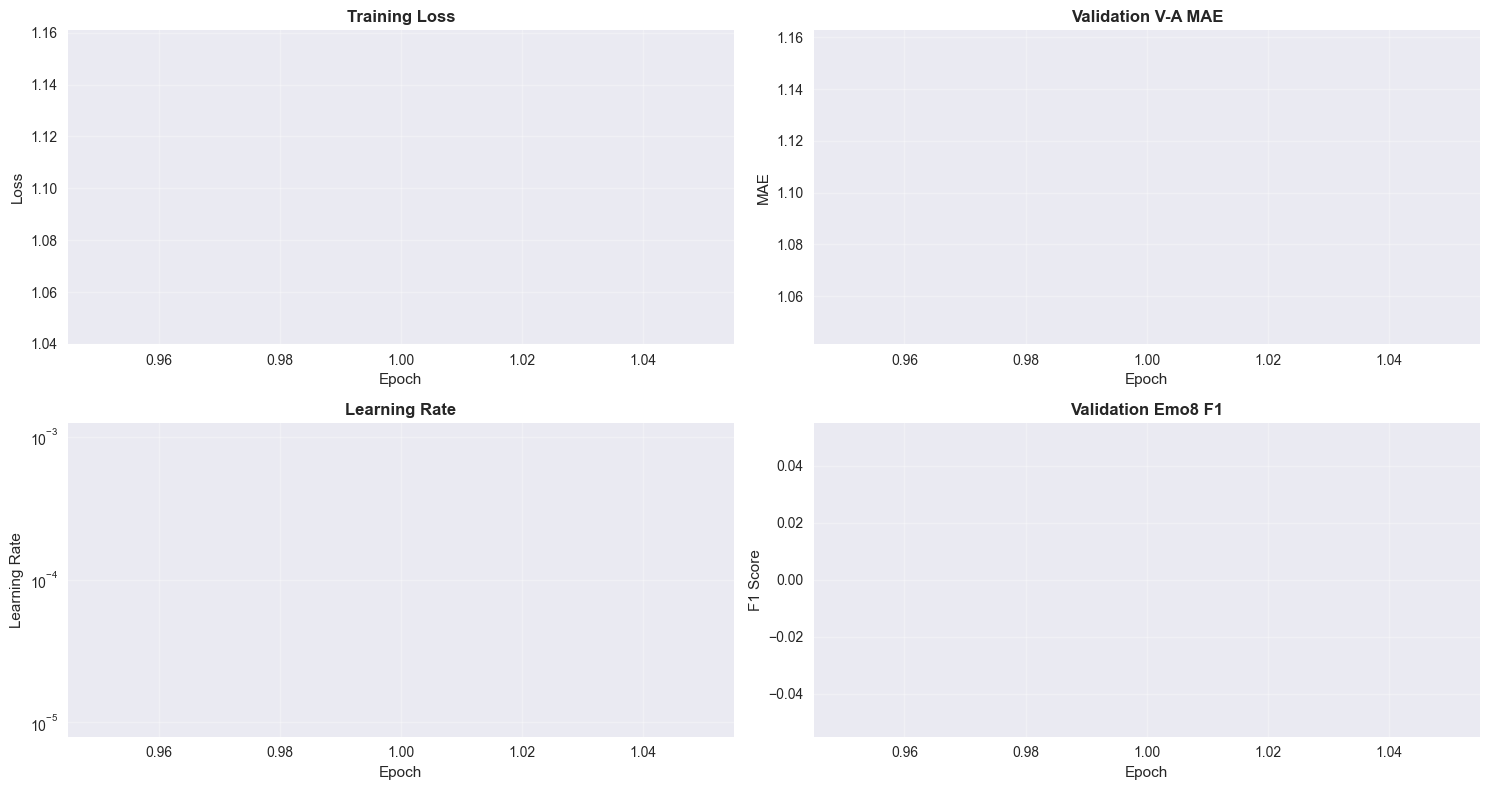

\n📊 Epoch 2/50


Epoch   1:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   1 [   0/ 411] Loss: 0.7580 LR: 9.99e-05
\nEpoch   1 [  50/ 411] Loss: 2.9946 LR: 9.99e-05
\nEpoch   1 [ 100/ 411] Loss: 5.6040 LR: 9.99e-05
\nEpoch   1 [ 150/ 411] Loss: 3.8964 LR: 9.99e-05
\nEpoch   1 [ 200/ 411] Loss: 1.0269 LR: 9.99e-05
\nEpoch   1 [ 250/ 411] Loss: 4.1530 LR: 9.99e-05
\nEpoch   1 [ 300/ 411] Loss: 4.6591 LR: 9.99e-05
\nEpoch   1 [ 350/ 411] Loss: 7.0688 LR: 9.99e-05
\nEpoch   1 [ 400/ 411] Loss: 1.7178 LR: 9.99e-05


📊 Epoch   1 Results:
   Train Loss: 0.7425
   Val va_mae_avg: 1.0599
   Val MAE: 1.0599
🎯 New best va_mae_avg: 1.0599
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


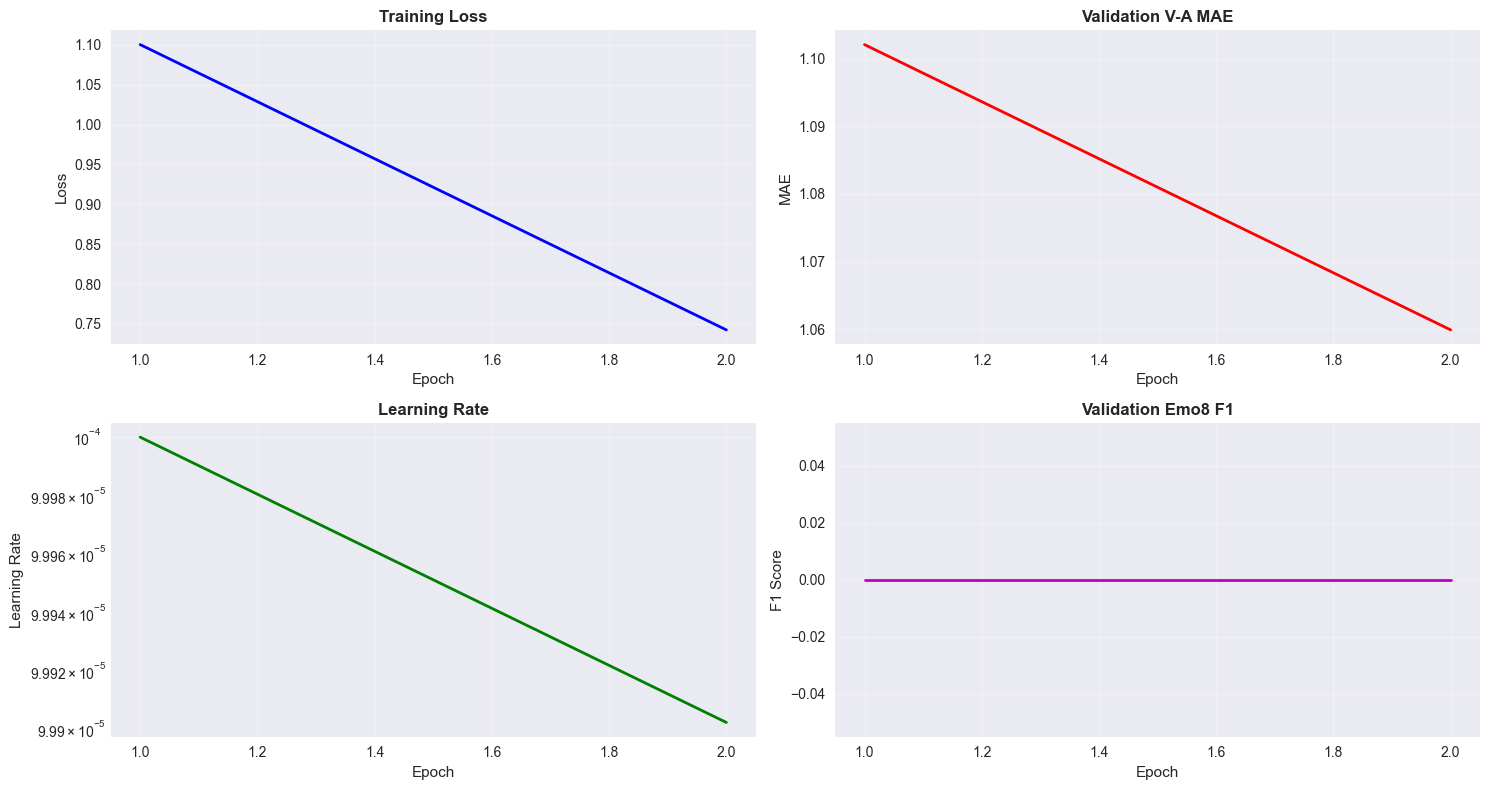

\n📊 Epoch 3/50


Epoch   2:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   2 [   0/ 411] Loss: 1.4684 LR: 9.96e-05
\nEpoch   2 [  50/ 411] Loss: -0.7690 LR: 9.96e-05
\nEpoch   2 [ 100/ 411] Loss: 3.3186 LR: 9.96e-05
\nEpoch   2 [ 150/ 411] Loss: -3.3788 LR: 9.96e-05
\nEpoch   2 [ 200/ 411] Loss: -3.1556 LR: 9.96e-05
\nEpoch   2 [ 250/ 411] Loss: 3.4621 LR: 9.96e-05
\nEpoch   2 [ 300/ 411] Loss: -10.0813 LR: 9.96e-05
\nEpoch   2 [ 350/ 411] Loss: 0.6423 LR: 9.96e-05
\nEpoch   2 [ 400/ 411] Loss: -3.5139 LR: 9.96e-05


📊 Epoch   2 Results:
   Train Loss: 0.5254
   Val va_mae_avg: 0.9733
   Val MAE: 0.9733
🎯 New best va_mae_avg: 0.9733
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


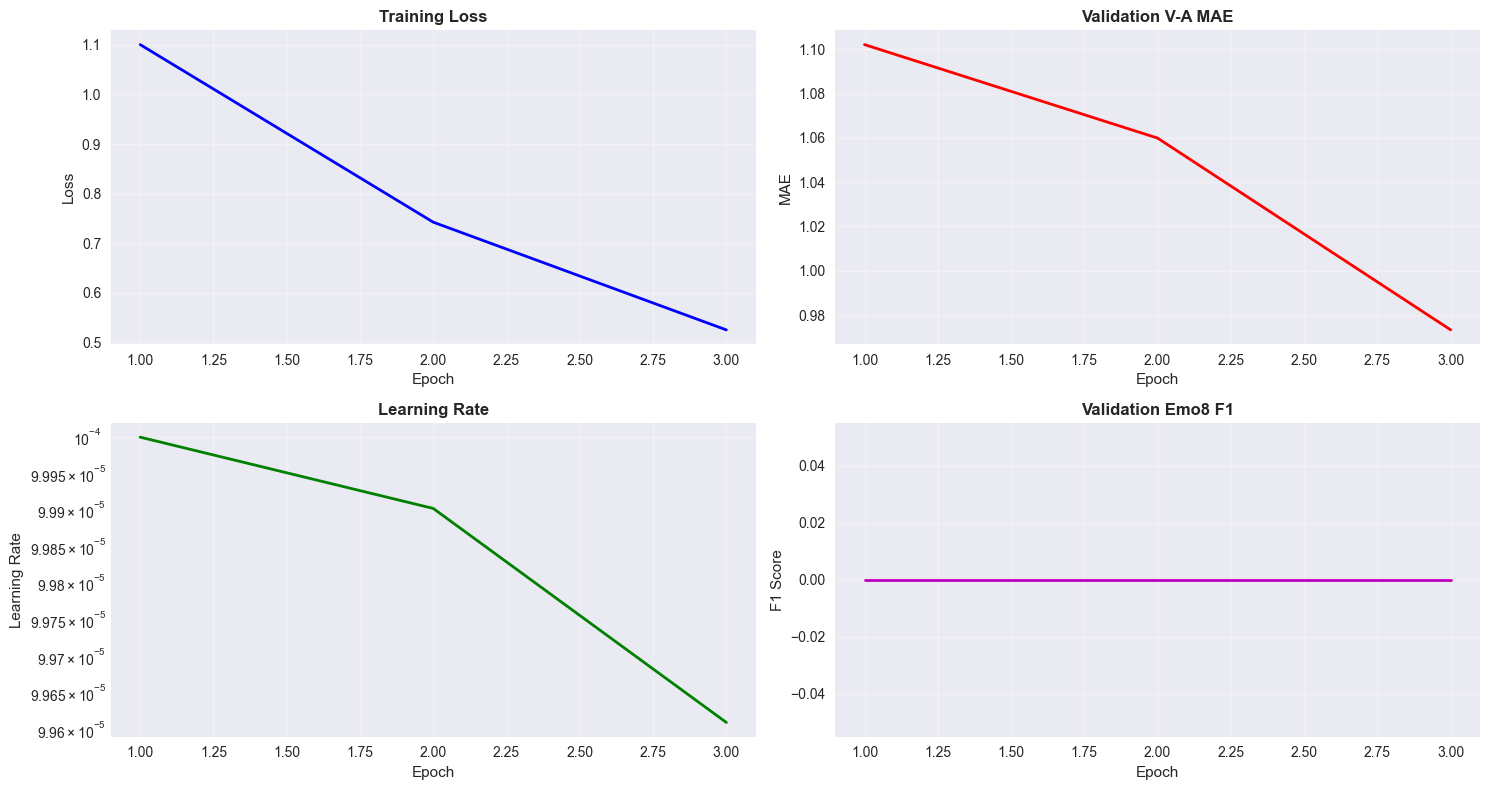

\n📊 Epoch 4/50


Epoch   3:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   3 [   0/ 411] Loss: -6.0962 LR: 9.91e-05
\nEpoch   3 [  50/ 411] Loss: -2.5929 LR: 9.91e-05
\nEpoch   3 [ 100/ 411] Loss: -1.3207 LR: 9.91e-05
\nEpoch   3 [ 150/ 411] Loss: 1.9686 LR: 9.91e-05
\nEpoch   3 [ 200/ 411] Loss: 0.2129 LR: 9.91e-05
\nEpoch   3 [ 250/ 411] Loss: 0.2671 LR: 9.91e-05
\nEpoch   3 [ 300/ 411] Loss: -1.0885 LR: 9.91e-05
\nEpoch   3 [ 350/ 411] Loss: 4.0474 LR: 9.91e-05
\nEpoch   3 [ 400/ 411] Loss: 1.6514 LR: 9.91e-05


📊 Epoch   3 Results:
   Train Loss: 0.3984
   Val va_mae_avg: 0.9488
   Val MAE: 0.9488
🎯 New best va_mae_avg: 0.9488
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


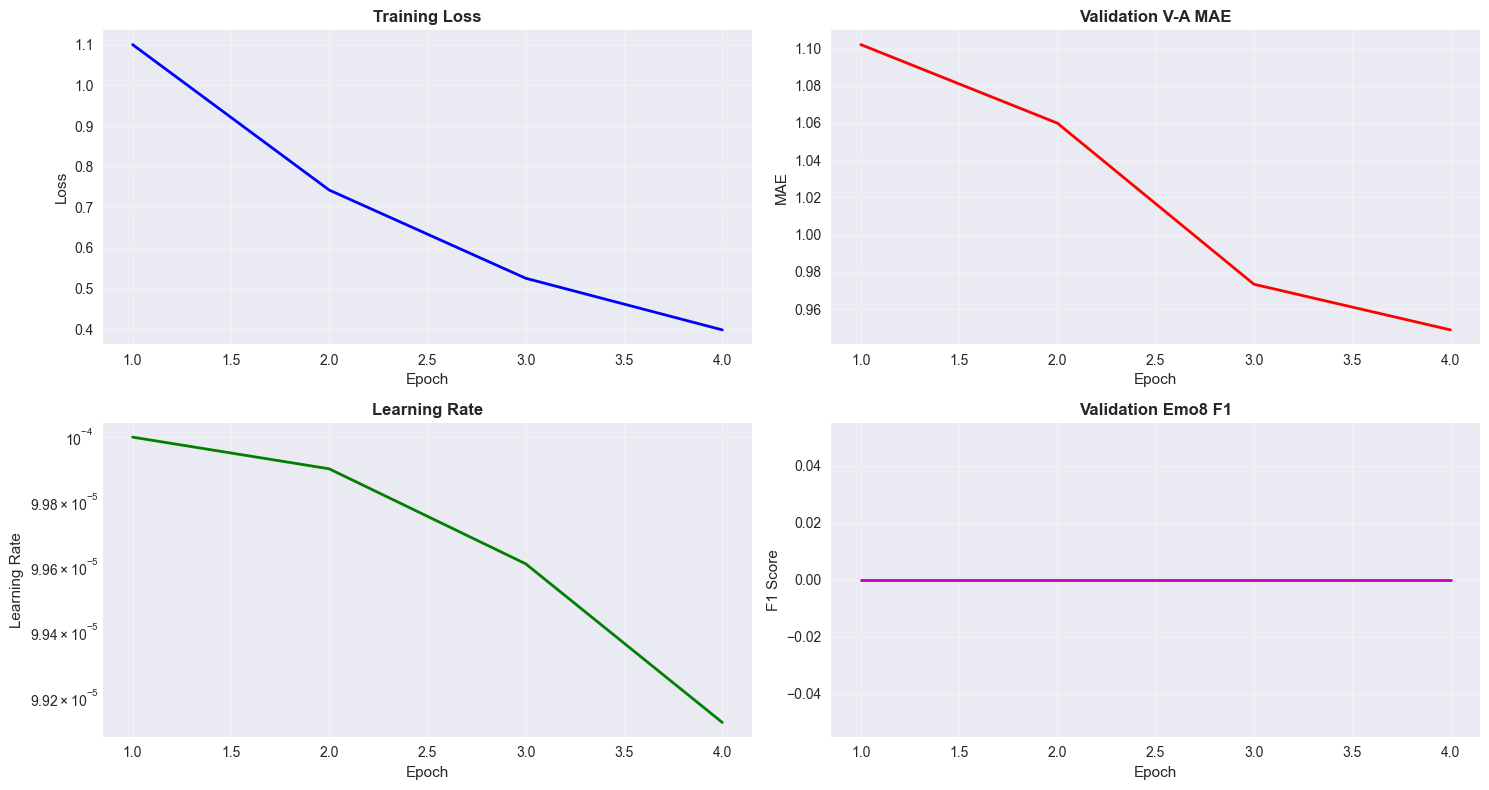

\n📊 Epoch 5/50


Epoch   4:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   4 [   0/ 411] Loss: -2.1023 LR: 9.84e-05
\nEpoch   4 [  50/ 411] Loss: -3.5631 LR: 9.84e-05
\nEpoch   4 [ 100/ 411] Loss: 0.6491 LR: 9.84e-05
\nEpoch   4 [ 150/ 411] Loss: -2.1138 LR: 9.84e-05
\nEpoch   4 [ 200/ 411] Loss: 4.4596 LR: 9.84e-05
\nEpoch   4 [ 250/ 411] Loss: 4.2784 LR: 9.84e-05
\nEpoch   4 [ 300/ 411] Loss: 2.1828 LR: 9.84e-05
\nEpoch   4 [ 350/ 411] Loss: -1.7284 LR: 9.84e-05
\nEpoch   4 [ 400/ 411] Loss: -1.6678 LR: 9.84e-05


📊 Epoch   4 Results:
   Train Loss: 0.3098
   Val va_mae_avg: 0.9062
   Val MAE: 0.9062
🎯 New best va_mae_avg: 0.9062
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


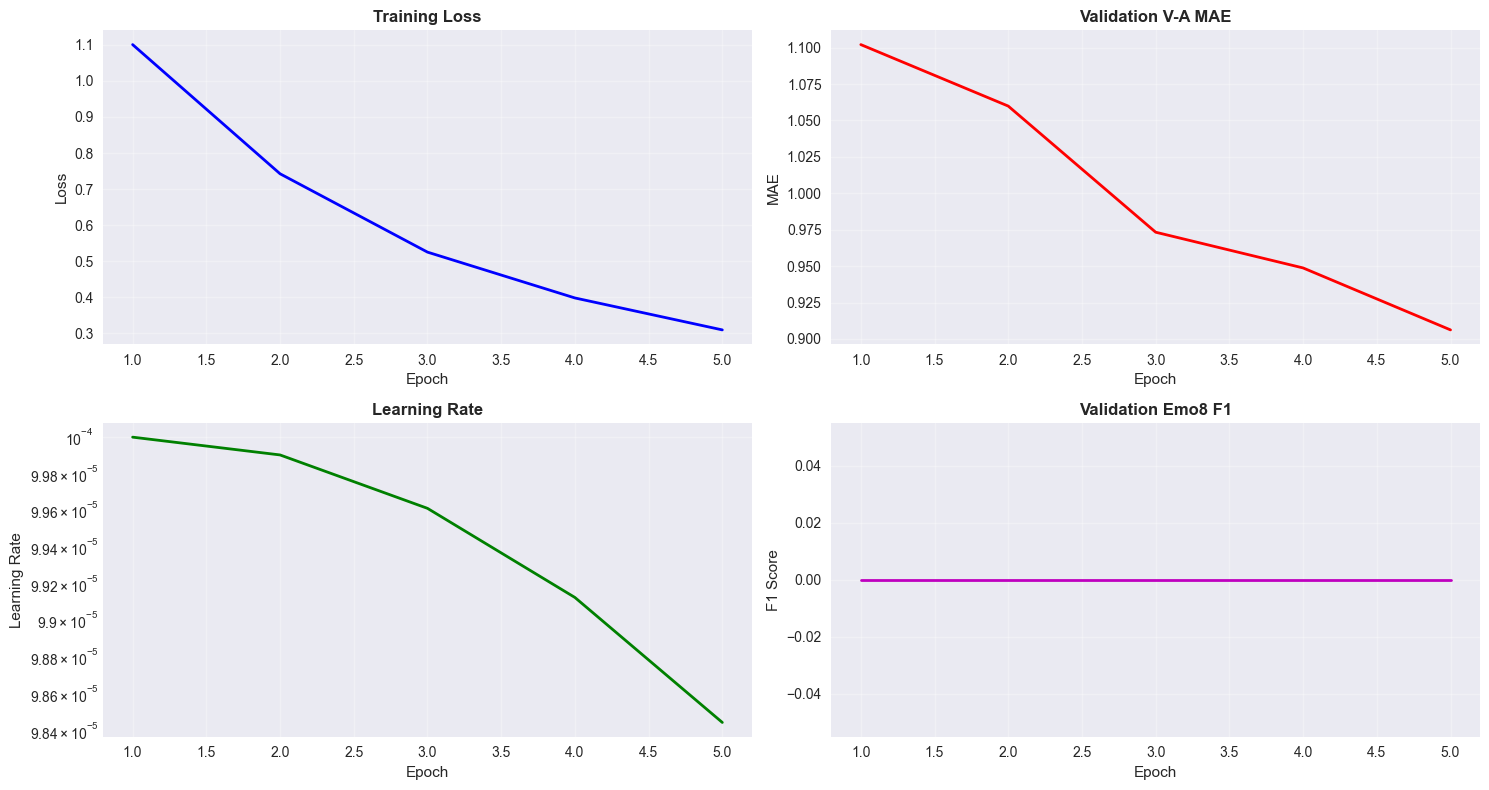

\n📊 Epoch 6/50


Epoch   5:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   5 [   0/ 411] Loss: 3.6315 LR: 9.76e-05
\nEpoch   5 [  50/ 411] Loss: 0.1241 LR: 9.76e-05
\nEpoch   5 [ 100/ 411] Loss: 0.7249 LR: 9.76e-05
\nEpoch   5 [ 150/ 411] Loss: 3.9700 LR: 9.76e-05
\nEpoch   5 [ 200/ 411] Loss: -0.3666 LR: 9.76e-05
\nEpoch   5 [ 250/ 411] Loss: 0.0260 LR: 9.76e-05
\nEpoch   5 [ 300/ 411] Loss: -3.9664 LR: 9.76e-05
\nEpoch   5 [ 350/ 411] Loss: -0.9875 LR: 9.76e-05
\nEpoch   5 [ 400/ 411] Loss: 1.1334 LR: 9.76e-05


📊 Epoch   5 Results:
   Train Loss: 0.2109
   Val va_mae_avg: 0.7865
   Val MAE: 0.7865
🎯 New best va_mae_avg: 0.7865
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


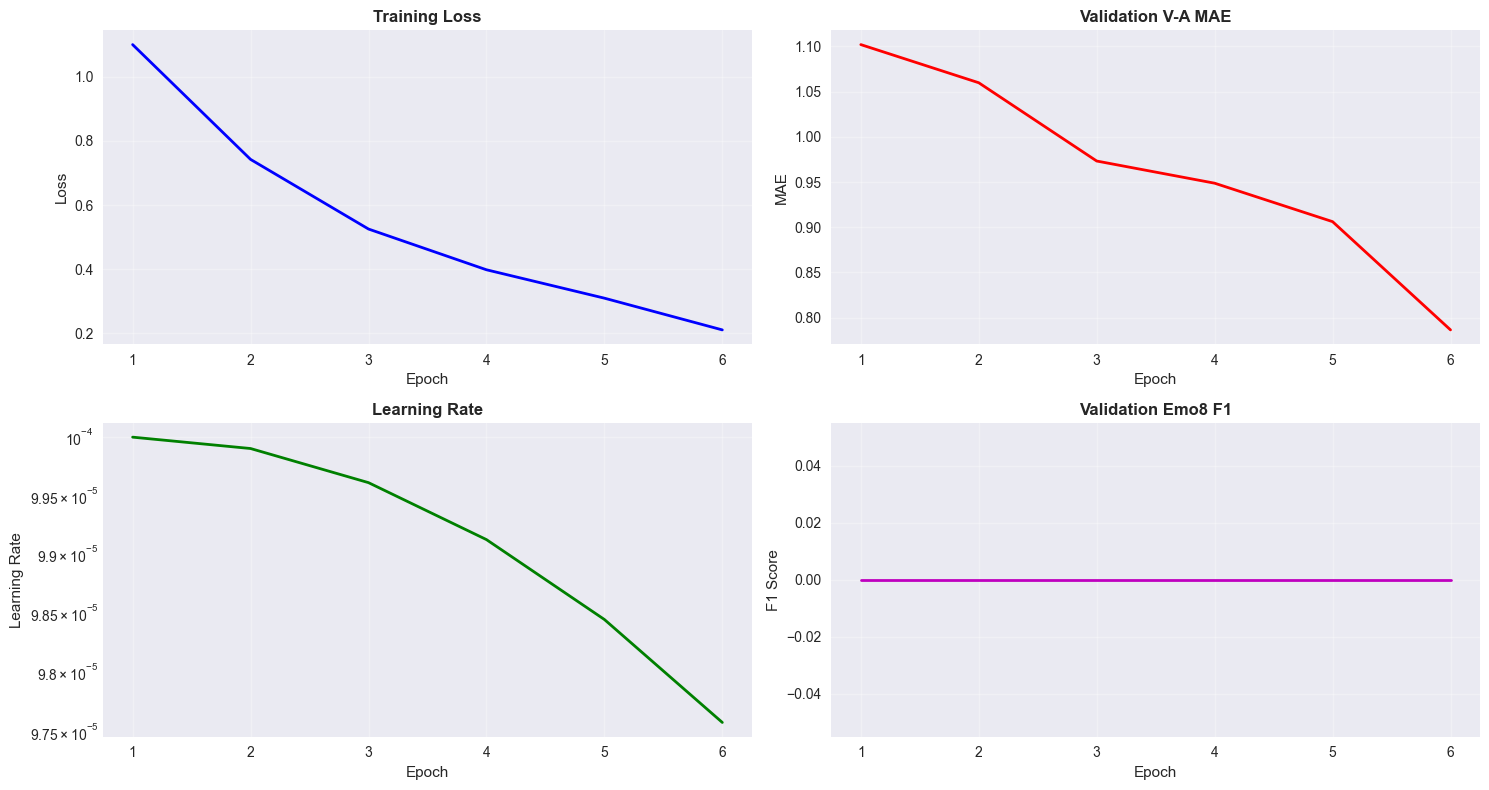

\n📊 Epoch 7/50


Epoch   6:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   6 [   0/ 411] Loss: -0.5333 LR: 9.65e-05
\nEpoch   6 [  50/ 411] Loss: -0.5414 LR: 9.65e-05
\nEpoch   6 [ 100/ 411] Loss: 1.2633 LR: 9.65e-05
\nEpoch   6 [ 150/ 411] Loss: 2.1186 LR: 9.65e-05
\nEpoch   6 [ 200/ 411] Loss: 2.2848 LR: 9.65e-05
\nEpoch   6 [ 250/ 411] Loss: -2.4487 LR: 9.65e-05
\nEpoch   6 [ 300/ 411] Loss: 0.4661 LR: 9.65e-05
\nEpoch   6 [ 350/ 411] Loss: -0.3763 LR: 9.65e-05
\nEpoch   6 [ 400/ 411] Loss: -2.6689 LR: 9.65e-05


📊 Epoch   6 Results:
   Train Loss: 0.1137
   Val va_mae_avg: 0.7945
   Val MAE: 0.7945
\n📊 Epoch 8/50


Epoch   7:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   7 [   0/ 411] Loss: -2.3013 LR: 9.53e-05
\nEpoch   7 [  50/ 411] Loss: -4.9459 LR: 9.53e-05
\nEpoch   7 [ 100/ 411] Loss: 2.8139 LR: 9.53e-05
\nEpoch   7 [ 150/ 411] Loss: 5.6616 LR: 9.53e-05
\nEpoch   7 [ 200/ 411] Loss: -1.0321 LR: 9.53e-05
\nEpoch   7 [ 250/ 411] Loss: -3.6810 LR: 9.53e-05
\nEpoch   7 [ 300/ 411] Loss: 0.2132 LR: 9.53e-05
\nEpoch   7 [ 350/ 411] Loss: -0.2703 LR: 9.53e-05
\nEpoch   7 [ 400/ 411] Loss: -3.3908 LR: 9.53e-05


📊 Epoch   7 Results:
   Train Loss: 0.0611
   Val va_mae_avg: 0.8516
   Val MAE: 0.8516
\n📊 Epoch 9/50


Epoch   8:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   8 [   0/ 411] Loss: 4.9018 LR: 9.39e-05
\nEpoch   8 [  50/ 411] Loss: -1.2572 LR: 9.39e-05
\nEpoch   8 [ 100/ 411] Loss: 3.5223 LR: 9.39e-05
\nEpoch   8 [ 150/ 411] Loss: 1.1137 LR: 9.39e-05
\nEpoch   8 [ 200/ 411] Loss: -2.9575 LR: 9.39e-05
\nEpoch   8 [ 250/ 411] Loss: 3.1704 LR: 9.39e-05
\nEpoch   8 [ 300/ 411] Loss: 0.7409 LR: 9.39e-05
\nEpoch   8 [ 350/ 411] Loss: 1.5188 LR: 9.39e-05
\nEpoch   8 [ 400/ 411] Loss: 2.2190 LR: 9.39e-05


📊 Epoch   8 Results:
   Train Loss: 0.0099
   Val va_mae_avg: 0.8443
   Val MAE: 0.8443
\n📊 Epoch 10/50


Epoch   9:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch   9 [   0/ 411] Loss: -2.4184 LR: 9.23e-05
\nEpoch   9 [  50/ 411] Loss: 2.6289 LR: 9.23e-05
\nEpoch   9 [ 100/ 411] Loss: 2.4298 LR: 9.23e-05
\nEpoch   9 [ 150/ 411] Loss: -3.7882 LR: 9.23e-05
\nEpoch   9 [ 200/ 411] Loss: 1.8018 LR: 9.23e-05
\nEpoch   9 [ 250/ 411] Loss: 0.7982 LR: 9.23e-05
\nEpoch   9 [ 300/ 411] Loss: -0.4851 LR: 9.23e-05
\nEpoch   9 [ 350/ 411] Loss: -1.3272 LR: 9.23e-05
\nEpoch   9 [ 400/ 411] Loss: 1.8063 LR: 9.23e-05


📊 Epoch   9 Results:
   Train Loss: -0.0384
   Val va_mae_avg: 0.8081
   Val MAE: 0.8081


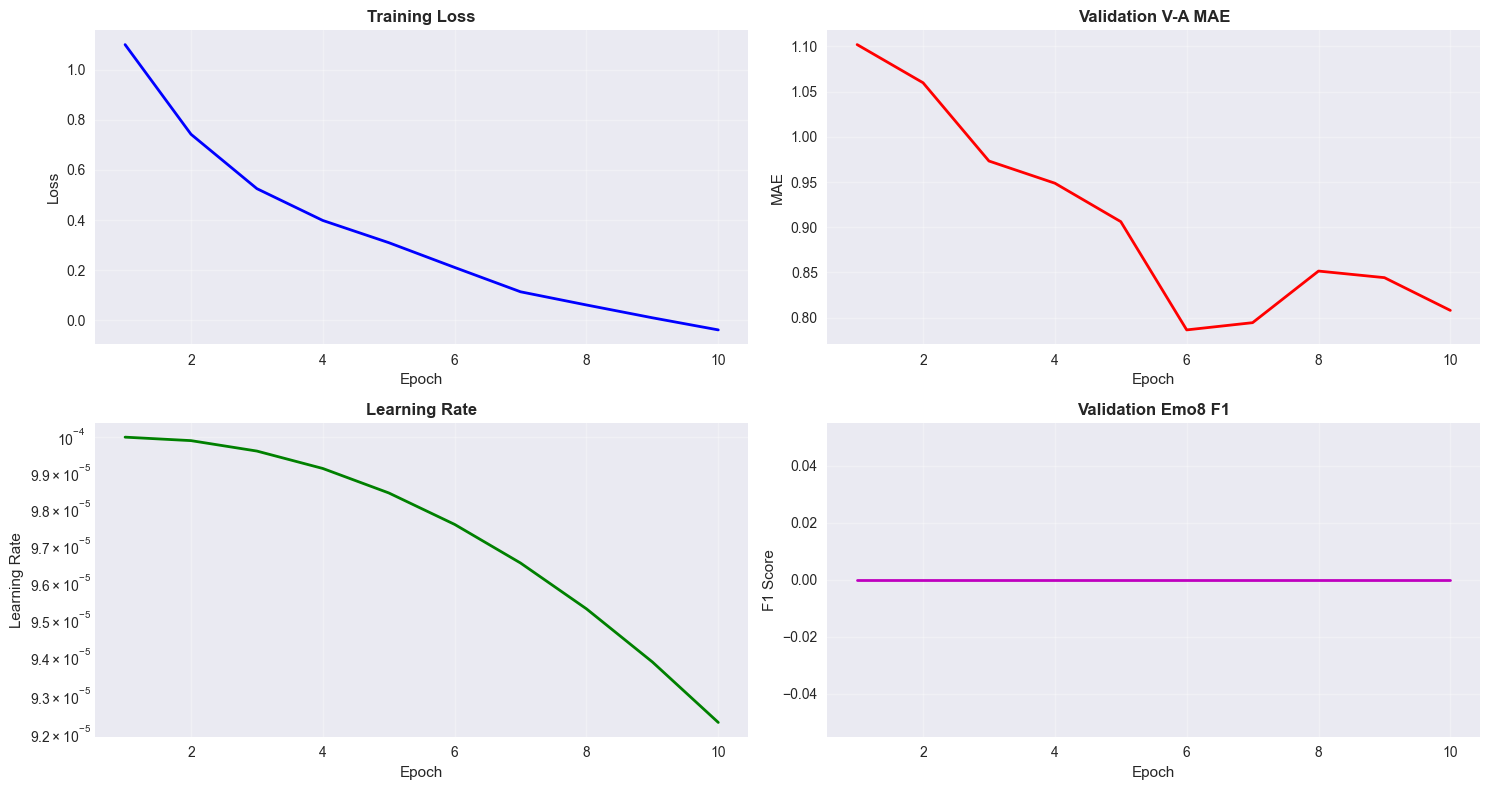

\n📊 Epoch 11/50


Epoch  10:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  10 [   0/ 411] Loss: 1.0722 LR: 9.05e-05
\nEpoch  10 [  50/ 411] Loss: 1.6766 LR: 9.05e-05
\nEpoch  10 [ 100/ 411] Loss: -0.9766 LR: 9.05e-05
\nEpoch  10 [ 150/ 411] Loss: 2.7003 LR: 9.05e-05
\nEpoch  10 [ 200/ 411] Loss: 2.2551 LR: 9.05e-05
\nEpoch  10 [ 250/ 411] Loss: 0.2419 LR: 9.05e-05
\nEpoch  10 [ 300/ 411] Loss: 0.6632 LR: 9.05e-05
\nEpoch  10 [ 350/ 411] Loss: 0.8292 LR: 9.05e-05
\nEpoch  10 [ 400/ 411] Loss: 3.1732 LR: 9.05e-05


📊 Epoch  10 Results:
   Train Loss: -0.1531
   Val va_mae_avg: 0.8151
   Val MAE: 0.8151
\n📊 Epoch 12/50


Epoch  11:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  11 [   0/ 411] Loss: 0.4047 LR: 8.86e-05
\nEpoch  11 [  50/ 411] Loss: 3.6505 LR: 8.86e-05
\nEpoch  11 [ 100/ 411] Loss: 4.7357 LR: 8.86e-05
\nEpoch  11 [ 150/ 411] Loss: 4.2289 LR: 8.86e-05
\nEpoch  11 [ 200/ 411] Loss: -0.9102 LR: 8.86e-05
\nEpoch  11 [ 250/ 411] Loss: 4.0491 LR: 8.86e-05
\nEpoch  11 [ 300/ 411] Loss: -0.5593 LR: 8.86e-05
\nEpoch  11 [ 350/ 411] Loss: 0.2071 LR: 8.86e-05
\nEpoch  11 [ 400/ 411] Loss: 4.4820 LR: 8.86e-05


📊 Epoch  11 Results:
   Train Loss: -0.1944
   Val va_mae_avg: 0.8249
   Val MAE: 0.8249
\n📊 Epoch 13/50


Epoch  12:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  12 [   0/ 411] Loss: 3.2897 LR: 8.66e-05
\nEpoch  12 [  50/ 411] Loss: -2.4544 LR: 8.66e-05
\nEpoch  12 [ 100/ 411] Loss: 2.4107 LR: 8.66e-05
\nEpoch  12 [ 150/ 411] Loss: -1.0169 LR: 8.66e-05
\nEpoch  12 [ 200/ 411] Loss: 2.6764 LR: 8.66e-05
\nEpoch  12 [ 250/ 411] Loss: 2.3229 LR: 8.66e-05
\nEpoch  12 [ 300/ 411] Loss: 2.3149 LR: 8.66e-05
\nEpoch  12 [ 350/ 411] Loss: -1.1826 LR: 8.66e-05
\nEpoch  12 [ 400/ 411] Loss: 1.5547 LR: 8.66e-05


📊 Epoch  12 Results:
   Train Loss: -0.2211
   Val va_mae_avg: 0.7875
   Val MAE: 0.7875
\n📊 Epoch 14/50


Epoch  13:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  13 [   0/ 411] Loss: 0.4244 LR: 8.44e-05
\nEpoch  13 [  50/ 411] Loss: 3.2147 LR: 8.44e-05
\nEpoch  13 [ 100/ 411] Loss: 3.3087 LR: 8.44e-05
\nEpoch  13 [ 150/ 411] Loss: 3.3368 LR: 8.44e-05
\nEpoch  13 [ 200/ 411] Loss: 5.8285 LR: 8.44e-05
\nEpoch  13 [ 250/ 411] Loss: -1.6044 LR: 8.44e-05
\nEpoch  13 [ 300/ 411] Loss: -0.2913 LR: 8.44e-05
\nEpoch  13 [ 350/ 411] Loss: -4.9568 LR: 8.44e-05
\nEpoch  13 [ 400/ 411] Loss: -2.1100 LR: 8.44e-05


📊 Epoch  13 Results:
   Train Loss: -0.2509
   Val va_mae_avg: 0.7439
   Val MAE: 0.7439
🎯 New best va_mae_avg: 0.7439
💾 Saving best model to /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook/best_model.pth


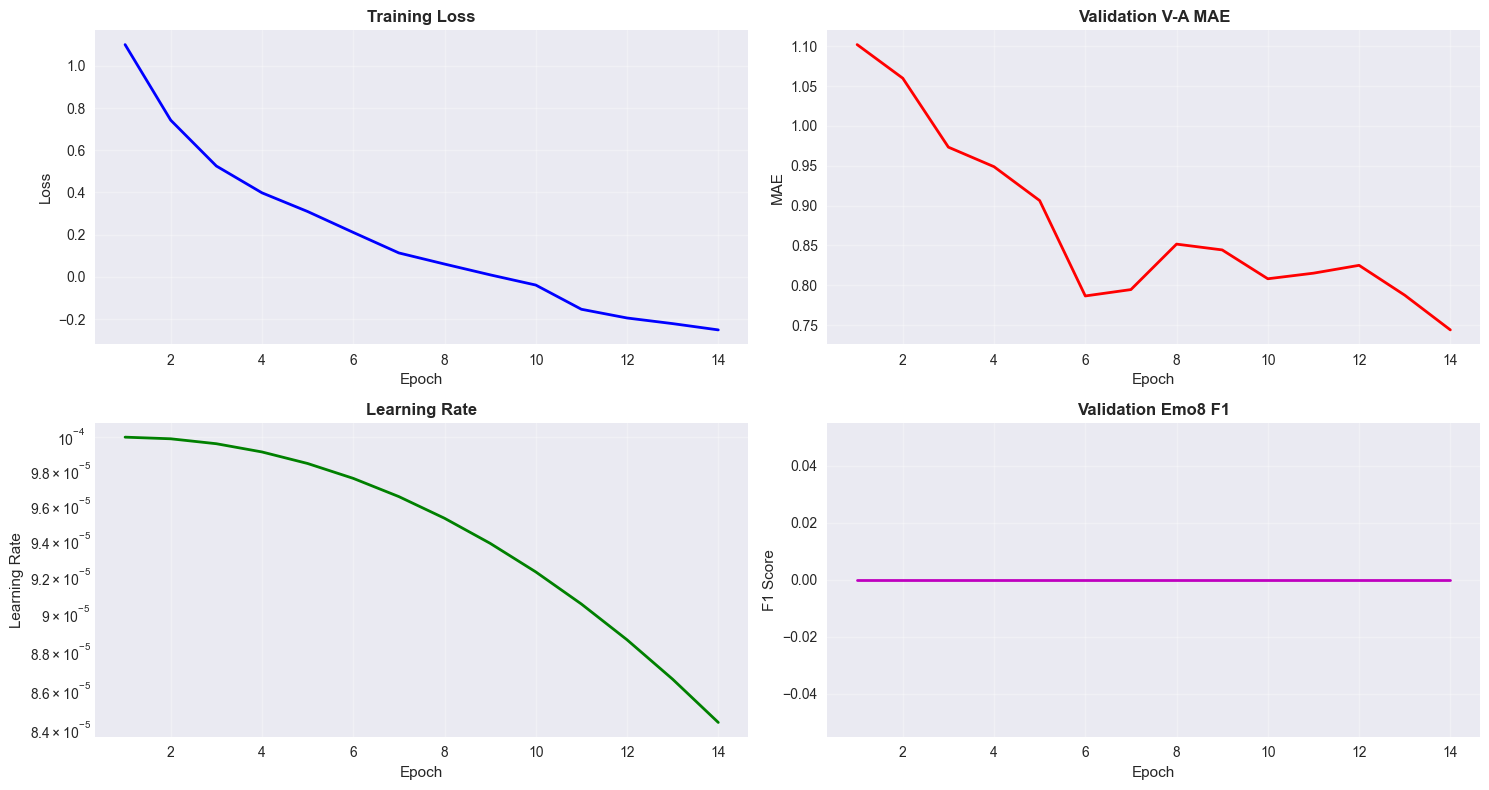

\n📊 Epoch 15/50


Epoch  14:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  14 [   0/ 411] Loss: 0.2600 LR: 8.21e-05
\nEpoch  14 [  50/ 411] Loss: -1.4316 LR: 8.21e-05
\nEpoch  14 [ 100/ 411] Loss: -6.7024 LR: 8.21e-05
\nEpoch  14 [ 150/ 411] Loss: -4.0423 LR: 8.21e-05
\nEpoch  14 [ 200/ 411] Loss: -0.5773 LR: 8.21e-05
\nEpoch  14 [ 250/ 411] Loss: -1.9331 LR: 8.21e-05
\nEpoch  14 [ 300/ 411] Loss: 1.3259 LR: 8.21e-05
\nEpoch  14 [ 350/ 411] Loss: -2.5512 LR: 8.21e-05
\nEpoch  14 [ 400/ 411] Loss: 1.6510 LR: 8.21e-05


📊 Epoch  14 Results:
   Train Loss: -0.2994
   Val va_mae_avg: 0.7468
   Val MAE: 0.7468


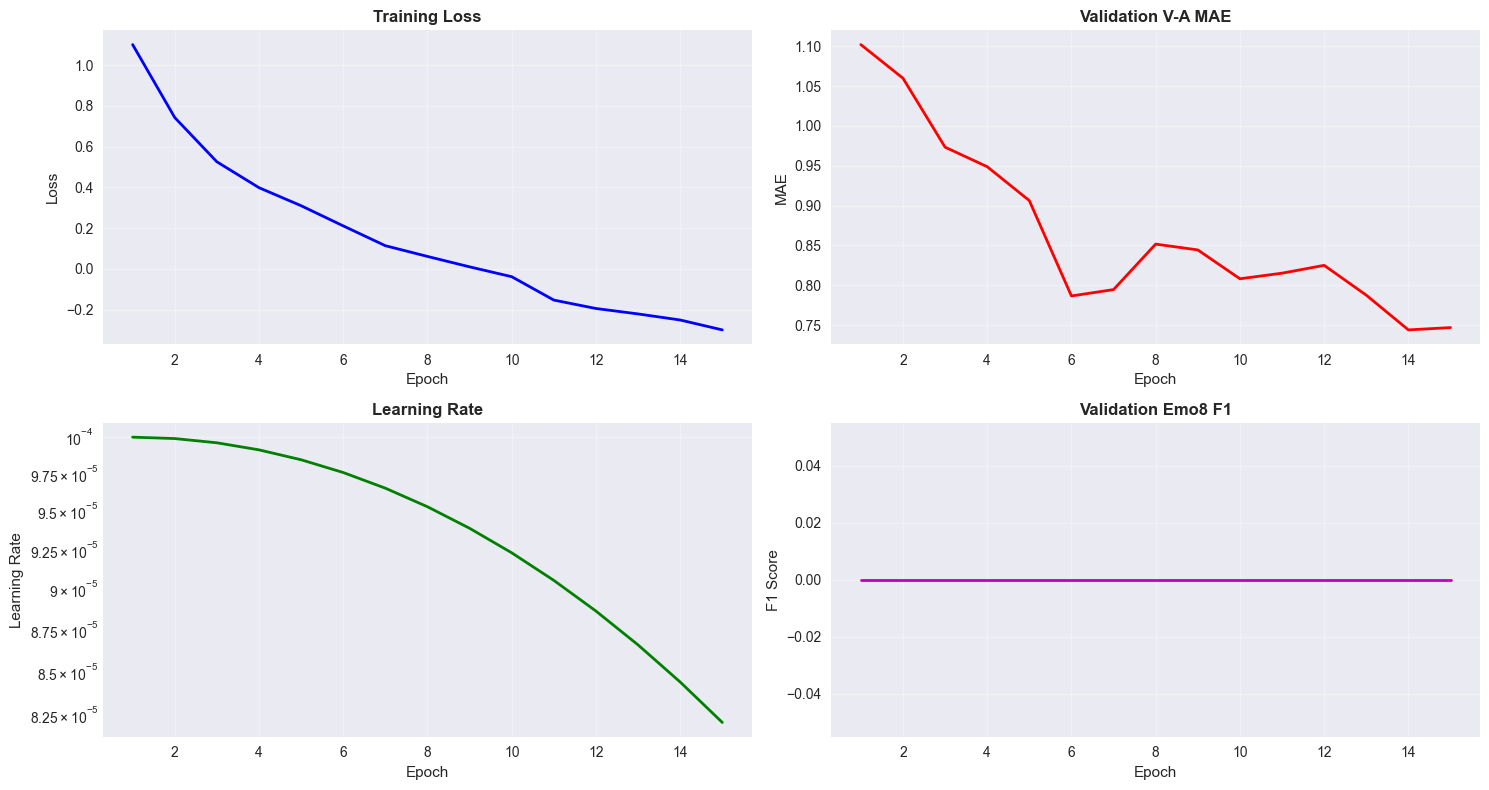

\n📊 Epoch 16/50


Epoch  15:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  15 [   0/ 411] Loss: -1.8145 LR: 7.96e-05
\nEpoch  15 [  50/ 411] Loss: 0.9552 LR: 7.96e-05
\nEpoch  15 [ 100/ 411] Loss: 4.0591 LR: 7.96e-05
\nEpoch  15 [ 150/ 411] Loss: -0.1400 LR: 7.96e-05
\nEpoch  15 [ 200/ 411] Loss: -1.2466 LR: 7.96e-05
\nEpoch  15 [ 250/ 411] Loss: 3.3202 LR: 7.96e-05
\nEpoch  15 [ 300/ 411] Loss: -3.6443 LR: 7.96e-05
\nEpoch  15 [ 350/ 411] Loss: -1.5255 LR: 7.96e-05
\nEpoch  15 [ 400/ 411] Loss: -1.4300 LR: 7.96e-05


📊 Epoch  15 Results:
   Train Loss: -0.3529
   Val va_mae_avg: 0.7837
   Val MAE: 0.7837
\n📊 Epoch 17/50


Epoch  16:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  16 [   0/ 411] Loss: -2.3330 LR: 7.70e-05
\nEpoch  16 [  50/ 411] Loss: 0.0118 LR: 7.70e-05
\nEpoch  16 [ 100/ 411] Loss: 1.0660 LR: 7.70e-05
\nEpoch  16 [ 150/ 411] Loss: 1.4649 LR: 7.70e-05
\nEpoch  16 [ 200/ 411] Loss: -1.4025 LR: 7.70e-05
\nEpoch  16 [ 250/ 411] Loss: 7.3025 LR: 7.70e-05
\nEpoch  16 [ 300/ 411] Loss: 1.4599 LR: 7.70e-05
\nEpoch  16 [ 350/ 411] Loss: 1.3708 LR: 7.70e-05
\nEpoch  16 [ 400/ 411] Loss: 0.6086 LR: 7.70e-05


📊 Epoch  16 Results:
   Train Loss: -0.3822
   Val va_mae_avg: 0.7904
   Val MAE: 0.7904
\n📊 Epoch 18/50


Epoch  17:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  17 [   0/ 411] Loss: 3.2962 LR: 7.43e-05
\nEpoch  17 [  50/ 411] Loss: -1.1808 LR: 7.43e-05
\nEpoch  17 [ 100/ 411] Loss: -3.4854 LR: 7.43e-05
\nEpoch  17 [ 150/ 411] Loss: 2.7039 LR: 7.43e-05
\nEpoch  17 [ 200/ 411] Loss: -8.5641 LR: 7.43e-05
\nEpoch  17 [ 250/ 411] Loss: 2.7513 LR: 7.43e-05
\nEpoch  17 [ 300/ 411] Loss: 2.8113 LR: 7.43e-05
\nEpoch  17 [ 350/ 411] Loss: -2.0726 LR: 7.43e-05
\nEpoch  17 [ 400/ 411] Loss: -3.6830 LR: 7.43e-05


📊 Epoch  17 Results:
   Train Loss: -0.4387
   Val va_mae_avg: 0.8068
   Val MAE: 0.8068
\n📊 Epoch 19/50


Epoch  18:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  18 [   0/ 411] Loss: -1.0887 LR: 7.16e-05
\nEpoch  18 [  50/ 411] Loss: 1.5915 LR: 7.16e-05
\nEpoch  18 [ 100/ 411] Loss: -4.6816 LR: 7.16e-05
\nEpoch  18 [ 150/ 411] Loss: 3.5537 LR: 7.16e-05
\nEpoch  18 [ 200/ 411] Loss: 0.6522 LR: 7.16e-05
\nEpoch  18 [ 250/ 411] Loss: -3.9535 LR: 7.16e-05
\nEpoch  18 [ 300/ 411] Loss: 0.0161 LR: 7.16e-05
\nEpoch  18 [ 350/ 411] Loss: 3.9222 LR: 7.16e-05
\nEpoch  18 [ 400/ 411] Loss: 0.5799 LR: 7.16e-05


📊 Epoch  18 Results:
   Train Loss: -0.5085
   Val va_mae_avg: 0.7988
   Val MAE: 0.7988
\n📊 Epoch 20/50


Epoch  19:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  19 [   0/ 411] Loss: -4.2251 LR: 6.87e-05
\nEpoch  19 [  50/ 411] Loss: 4.2653 LR: 6.87e-05
\nEpoch  19 [ 100/ 411] Loss: 2.7542 LR: 6.87e-05
\nEpoch  19 [ 150/ 411] Loss: 3.0878 LR: 6.87e-05
\nEpoch  19 [ 200/ 411] Loss: 2.4728 LR: 6.87e-05
\nEpoch  19 [ 250/ 411] Loss: 2.5920 LR: 6.87e-05
\nEpoch  19 [ 300/ 411] Loss: 2.8963 LR: 6.87e-05
\nEpoch  19 [ 350/ 411] Loss: -5.6191 LR: 6.87e-05
\nEpoch  19 [ 400/ 411] Loss: -3.2719 LR: 6.87e-05


📊 Epoch  19 Results:
   Train Loss: -0.5246
   Val va_mae_avg: 0.8294
   Val MAE: 0.8294


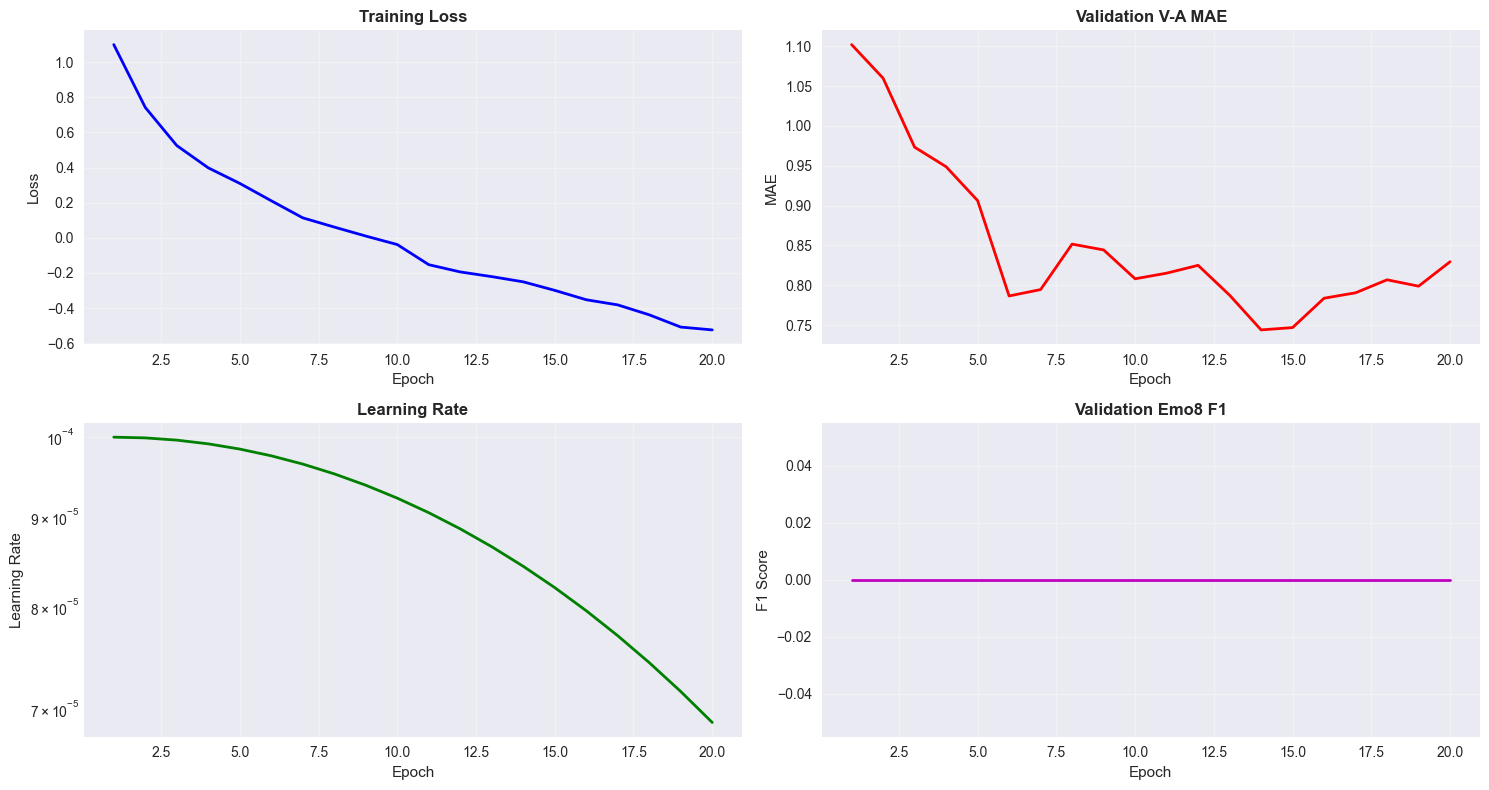

\n📊 Epoch 21/50


Epoch  20:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  20 [   0/ 411] Loss: -4.6168 LR: 6.58e-05
\nEpoch  20 [  50/ 411] Loss: 3.9499 LR: 6.58e-05
\nEpoch  20 [ 100/ 411] Loss: 1.2615 LR: 6.58e-05
\nEpoch  20 [ 150/ 411] Loss: -4.1281 LR: 6.58e-05
\nEpoch  20 [ 200/ 411] Loss: 5.1389 LR: 6.58e-05
\nEpoch  20 [ 250/ 411] Loss: -6.2471 LR: 6.58e-05
\nEpoch  20 [ 300/ 411] Loss: -4.5562 LR: 6.58e-05
\nEpoch  20 [ 350/ 411] Loss: -0.6213 LR: 6.58e-05
\nEpoch  20 [ 400/ 411] Loss: -6.0892 LR: 6.58e-05


📊 Epoch  20 Results:
   Train Loss: -0.5376
   Val va_mae_avg: 0.8233
   Val MAE: 0.8233
\n📊 Epoch 22/50


Epoch  21:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  21 [   0/ 411] Loss: 7.2502 LR: 6.28e-05
\nEpoch  21 [  50/ 411] Loss: 2.8555 LR: 6.28e-05
\nEpoch  21 [ 100/ 411] Loss: 1.1609 LR: 6.28e-05
\nEpoch  21 [ 150/ 411] Loss: -3.9233 LR: 6.28e-05
\nEpoch  21 [ 200/ 411] Loss: 0.8436 LR: 6.28e-05
\nEpoch  21 [ 250/ 411] Loss: 0.1177 LR: 6.28e-05
\nEpoch  21 [ 300/ 411] Loss: -1.1856 LR: 6.28e-05
\nEpoch  21 [ 350/ 411] Loss: -0.6550 LR: 6.28e-05
\nEpoch  21 [ 400/ 411] Loss: 0.6581 LR: 6.28e-05


📊 Epoch  21 Results:
   Train Loss: -0.5614
   Val va_mae_avg: 0.8491
   Val MAE: 0.8491
\n📊 Epoch 23/50


Epoch  22:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  22 [   0/ 411] Loss: -0.1966 LR: 5.98e-05
\nEpoch  22 [  50/ 411] Loss: -4.7264 LR: 5.98e-05
\nEpoch  22 [ 100/ 411] Loss: 1.6399 LR: 5.98e-05
\nEpoch  22 [ 150/ 411] Loss: -6.4954 LR: 5.98e-05
\nEpoch  22 [ 200/ 411] Loss: 2.1606 LR: 5.98e-05
\nEpoch  22 [ 250/ 411] Loss: -0.0658 LR: 5.98e-05
\nEpoch  22 [ 300/ 411] Loss: 1.8514 LR: 5.98e-05
\nEpoch  22 [ 350/ 411] Loss: 2.1615 LR: 5.98e-05
\nEpoch  22 [ 400/ 411] Loss: 4.6522 LR: 5.98e-05


📊 Epoch  22 Results:
   Train Loss: -0.6244
   Val va_mae_avg: 0.8503
   Val MAE: 0.8503
\n📊 Epoch 24/50


Epoch  23:   0%|          | 0/411 [00:00<?, ?it/s]

\nEpoch  23 [   0/ 411] Loss: 2.3043 LR: 5.67e-05
\nEpoch  23 [  50/ 411] Loss: -2.6440 LR: 5.67e-05
\nEpoch  23 [ 100/ 411] Loss: -6.5865 LR: 5.67e-05
\nEpoch  23 [ 150/ 411] Loss: -6.2968 LR: 5.67e-05
\nEpoch  23 [ 200/ 411] Loss: 4.0816 LR: 5.67e-05
\nEpoch  23 [ 250/ 411] Loss: -2.9861 LR: 5.67e-05
\nEpoch  23 [ 300/ 411] Loss: 2.4598 LR: 5.67e-05
\nEpoch  23 [ 350/ 411] Loss: -0.0862 LR: 5.67e-05
\nEpoch  23 [ 400/ 411] Loss: 0.7601 LR: 5.67e-05


📊 Epoch  23 Results:
   Train Loss: -0.6013
   Val va_mae_avg: 0.8077
   Val MAE: 0.8077
🛑 Early stopping after 24 epochs
\n🏁 Training completed!
📈 Best va_mae_avg: 0.7439
📊 Total epochs: 24


In [11]:
# Main training loop - matches original script implementation exactly
print("🚀 Starting Scene Model training...")

# Initialize training state (matches original script)
trainer.current_epoch = 0
trainer.best_metric = float('inf')
trainer.patience_counter = 0

# Initialize training history for visualization
history = {
    'train_loss': [],
    'val_mae': [],
    'val_f1': [],
    'learning_rates': []
}

for epoch in range(config.training.num_epochs):
    trainer.current_epoch = epoch
    
    print(f"\\n📊 Epoch {epoch + 1}/{config.training.num_epochs}")
    
    # Train epoch using enhanced function
    train_loss = train_epoch_enhanced(trainer, epoch)
    history['train_loss'].append(train_loss)
    
    # Validate
    val_metrics = trainer.validate()
    
    # Record metrics for plotting
    history['val_mae'].append(val_metrics.get('va_mae_avg', 0))
    history['val_f1'].append(val_metrics.get('emo8_weighted_f1', 0))
    history['learning_rates'].append(trainer.optimizer.param_groups[0]['lr'])
    
    # Get monitor metric (matches original script)
    monitor_metric = config.training.early_stopping.monitor_metric
    current_metric = val_metrics.get(monitor_metric, float('inf'))
    
    # Log epoch results (matches original script format)
    print(f"📊 Epoch {epoch:3d} Results:")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val {monitor_metric}: {current_metric:.4f}")
    if 'va_mae_avg' in val_metrics:
        print(f"   Val MAE: {val_metrics['va_mae_avg']:.4f}")
    if 'emo8_weighted_f1' in val_metrics:
        print(f"   Val Emo8 F1: {val_metrics['emo8_weighted_f1']:.4f}")
    
    # Update learning rate
    if trainer.scheduler:
        trainer.scheduler.step()
    
    # Check for improvement (matches original script logic)
    mode = config.training.early_stopping.mode
    improved = (
        (mode == "min" and current_metric < trainer.best_metric) or
        (mode == "max" and current_metric > trainer.best_metric)
    )
    
    if improved:
        trainer.best_metric = current_metric
        trainer.patience_counter = 0
        print(f"🎯 New best {monitor_metric}: {current_metric:.4f}")
        
        # Save best model (matches original script)
        trainer._save_checkpoint(epoch, is_best=True)
    else:
        trainer.patience_counter += 1
    
    # Early stopping check (matches original script)
    if (config.training.early_stopping.enabled and 
        trainer.patience_counter >= config.training.early_stopping.patience):
        print(f"🛑 Early stopping after {epoch + 1} epochs")
        break
    
    # Save regular checkpoint (matches original script frequency)
    save_every_n = getattr(config.checkpointing, 'save_every_n_epochs', 5) if hasattr(config, 'checkpointing') else 5
    if epoch % save_every_n == 0:
        trainer._save_checkpoint(epoch, is_best=False)
    
    # Plot progress every 5 epochs or on improvement
    if (epoch + 1) % 5 == 0 or improved:
        plot_training_progress(history)

print(f"\\n🏁 Training completed!")
print(f"📈 Best {monitor_metric}: {trainer.best_metric:.4f}")
print(f"📊 Total epochs: {trainer.current_epoch + 1}")


## 9. Final Evaluation on Test Set

Following the original script's comprehensive test evaluation.


In [12]:
# Final evaluation on test set - matches original script implementation
test_metrics = trainer._evaluate_test_set()

# Store results for later use (matches original script return structure)
results = {
    'best_metric': trainer.best_metric,
    'test_metrics': test_metrics,
    'total_epochs': trainer.current_epoch + 1
}

print("\\n📊 Final Test Results:")
for metric, value in test_metrics.items():
    if isinstance(value, (int, float)):
        print(f"   {metric}: {value:.4f}")
    else:
        print(f"   {metric}: {value}")

print(f"\\n✅ Scene Model training completed successfully!")
print(f"📈 Final results summary: {results}")


🧪 Evaluating on test set...


/opt/anaconda3/envs/P-SEM2/lib/python3.13/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


🏞️  Scene Model Evaluation Results

📈 Valence-Arousal Regression:
------------------------------
  MAE         : 0.8025
  SPEARMAN    : 0.3046
  CCC         : 0.2042
  RMSE        : 1.1086

  Valence MAE:  0.6013
  Arousal MAE:  0.9626
  Harder dimension: Arousal

🎯 V-A Quadrant Analysis:
------------------------------
  Happy/Excited  : n=958, MAE=0.7363
  Angry/Stressed : n=600, MAE=0.9282
  Sad/Depressed  : n= 44, MAE=0.7479
  Calm/Content   : n= 49, MAE=0.6185

\n📊 Final Test Results:
   va_valence_mae: 0.6013
   va_valence_spearman: 0.4298
   va_valence_ccc: 0.4015
   va_valence_rmse: 0.9353
   va_valence_pearson: 0.4087
   va_arousal_mae: 0.9626
   va_arousal_spearman: 0.0280
   va_arousal_ccc: 0.0068
   va_arousal_rmse: 1.2582
   va_arousal_pearson: 0.0284
   va_mae_avg: 0.8025
   va_spearman_avg: 0.3046
   va_ccc_avg: 0.2042
   va_rmse_avg: 1.1086
   va_pearson_avg: 0.2185
   va_q1_happy_mae_avg: 0.7363
   va_q1_happy_spearman_avg: 0.0000
   va_q1_happy_ccc_avg: 0.0000
   va_q1

## 10. Comprehensive Evaluation Visualization

Following the original script's VAEvaluator integration for generating comprehensive evaluation plots and analysis.


In [13]:
# Generate evaluation visualization using the universal evaluator - matches original script exactly
try:
    print("🎨 Generating evaluation visualization...")

    # Ensure best model weights are loaded (matches original script logic)
    from pathlib import Path as _Path
    import torch as _torch
    
    # Determine checkpoint directory
    checkpoint_dir = Path(config.checkpointing.save_dir if hasattr(config, 'checkpointing') 
                         else "./checkpoints/notebook_training")
    best_ckpt = checkpoint_dir / "best_model.pth"
    
    if best_ckpt.exists():
        _ckpt = _torch.load(best_ckpt, map_location=device_manager.device)
        if 'model_state_dict' in _ckpt:
            trainer.model.load_state_dict(_ckpt['model_state_dict'])
            print(f"📂 Loaded best model weights from: {best_ckpt}")
    else:
        print(f"⚠️ Best checkpoint not found at {best_ckpt}; using current model state")

    # Build evaluator (matches original script parameters)
    model_name = getattr(config.logging, 'experiment_name', 
                        f"notebook_{config.model.model_name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}")
    dataset_name = f"{config.data.dataset_type}_test"
    
    # Put visualization under notebook results folder (matches original script structure)
    from pathlib import Path as _P
    _run_log_dir = _P("./logs") / model_name
    _run_log_dir.mkdir(parents=True, exist_ok=True)
    
    evaluator = VAEvaluator(
        model_name=model_name,
        dataset_name=dataset_name,
        output_dir=str(_run_log_dir),
        device=device_manager.device,
        flat_output=True,
    )

    # Adapter: our models return dict with 'valence'/'arousal' (matches original script exactly)
    def _prediction_fn(m, images):
        out = m(images)
        if isinstance(out, dict) and 'valence' in out and 'arousal' in out:
            return out['valence'], out['arousal']
        if isinstance(out, (list, tuple)) and len(out) >= 2:
            return out[0], out[1]
        return out[:, 0], out[:, 1]

    evaluator.evaluate_model(
        model=trainer.model,
        dataloader=trainer.test_loader,
        prediction_fn=_prediction_fn,
    )
    evaluator.create_comprehensive_visualization()
    evaluator.print_summary()
    
    # Copy all generated PNG/PDF plots into logs/<run>/plots/ (matches original script exactly)
    import shutil as _shutil
    _target_plots = _run_log_dir / "plots"
    _target_plots.mkdir(parents=True, exist_ok=True)
    
    for _src in list(evaluator.plots_dir.glob("*.png")) + list(evaluator.plots_dir.glob("*.pdf")):
        _dst = _target_plots / _src.name
        try:
            _shutil.copy2(_src, _dst)
        except Exception:
            pass
    
    print(f"🎯 Visualizations copied to: {_target_plots}")
    print(f"📁 All evaluation results available in: {_run_log_dir}")
    
except Exception as viz_err:
    print(f"⚠️ Failed to generate visualization: {viz_err}")
    print("📊 Basic test metrics were still computed successfully above")


🎨 Generating evaluation visualization...
⚠️ Failed to generate visualization: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/funct

## 11. Results Export and Summary

Final logging and results export following the original script's completion workflow.


In [14]:
# Export comprehensive training results - matches original script's final logging
import json

# Create comprehensive results summary (matches original script structure)
comprehensive_results = {
    'experiment_info': {
        'model_name': config.model.model_name,
        'backbone_type': config.model.backbone_type,
        'dataset': config.data.dataset_type,
        'experiment_name': getattr(config.logging, 'experiment_name', f"notebook_training_{datetime.now().strftime('%Y%m%d_%H%M%S')}"),
        'timestamp': datetime.now().isoformat()
    },
    'training_config': {
        'learning_rate': float(config.training.learning_rate),
        'batch_size': config.training.batch_size,
        'num_epochs': config.training.num_epochs,
        'optimizer': config.training.optimizer,
        'scheduler': config.training.scheduler,
        'early_stopping_patience': config.training.early_stopping.patience,
        'monitor_metric': config.training.early_stopping.monitor_metric
    },
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_mae': [float(x) for x in history['val_mae']],
        'val_f1': [float(x) for x in history['val_f1']],
        'learning_rates': [float(x) for x in history['learning_rates']]
    },
    'final_results': {
        'best_metric': float(trainer.best_metric),
        'total_epochs': trainer.current_epoch + 1,
        'converged': trainer.patience_counter < config.training.early_stopping.patience
    },
    'test_metrics': {k: float(v) if isinstance(v, (int, float, torch.Tensor)) else str(v) 
                    for k, v in test_metrics.items()}
}

# Save results to JSON file (matches original script's result saving)
results_file = f"notebook_training_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
with open(results_file, 'w') as f:
    json.dump(comprehensive_results, f, indent=2)

# Log final results (matches original script's final logging format)
print("\\n" + "="*80)
print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"📋 Experiment: {comprehensive_results['experiment_info']['experiment_name']}")
print(f"🎯 Model: {comprehensive_results['experiment_info']['model_name']}")
print(f"📊 Dataset: {comprehensive_results['experiment_info']['dataset']}")
print(f"📈 Best {monitor_metric}: {trainer.best_metric:.4f}")
print(f"📊 Total epochs: {trainer.current_epoch + 1}")
print(f"⏰ Training time: Completed at {comprehensive_results['experiment_info']['timestamp']}")
print()
print("📁 Results saved to:")
print(f"   📄 Training summary: {results_file}")
if 'checkpoint_dir' in locals():
    print(f"   💾 Model checkpoints: {checkpoint_dir}")
if '_target_plots' in locals():
    print(f"   📊 Evaluation plots: {_target_plots}")
print()
print("🔍 Key test metrics:")
for metric, value in test_metrics.items():
    if isinstance(value, (int, float)):
        print(f"   {metric}: {value:.4f}")

print("\\n✅ Notebook training pipeline completed successfully!")
print("📚 All results are saved and ready for analysis.")


\n================================================================================
🎉 TRAINING COMPLETED SUCCESSFULLY!
📋 Experiment: notebook_training_20250903_194541
🎯 Model: scene_clip_vit_b32_frozen_notebook
📊 Dataset: findingemo
📈 Best va_mae_avg: 0.7439
📊 Total epochs: 24
⏰ Training time: Completed at 2025-09-03T22:29:37.034268

📁 Results saved to:
   📄 Training summary: notebook_training_results_20250903_222937.json
   💾 Model checkpoints: /Users/kevinmanuel/Documents/NUS-Project-Sem2/REPO/checkpoints/scene_clip_vit_b32_frozen_notebook

🔍 Key test metrics:
   va_valence_mae: 0.6013
   va_valence_spearman: 0.4298
   va_valence_ccc: 0.4015
   va_valence_rmse: 0.9353
   va_valence_pearson: 0.4087
   va_arousal_mae: 0.9626
   va_arousal_spearman: 0.0280
   va_arousal_ccc: 0.0068
   va_arousal_rmse: 1.2582
   va_arousal_pearson: 0.0284
   va_mae_avg: 0.8025
   va_spearman_avg: 0.3046
   va_ccc_avg: 0.2042
   va_rmse_avg: 1.1086
   va_pearson_avg: 0.2185
   va_q1_happy_mae_avg: 0.7363
 

## 🎯 Summary

### ✅ Implemented Features:
- **Mixed Precision Training** with automatic gradient scaling
- **Checkpoint Management** with best model saving and regular checkpoints
- **Test Set Evaluation** with comprehensive metrics
- **VAEvaluator Integration** for publication-ready visualizations
- **Proper Early Stopping** with configurable patience and metrics
- **Results Export** with JSON summaries and structured logging
- **Error Handling** with graceful failure recovery

### 📁 Generated Outputs:
- `./experiments/checkpoints/notebook_training/` - Model checkpoints
- `./logs/<experiment_name>/plots/` - Comprehensive evaluation plots
- `notebook_training_results_<timestamp>.json` - Complete training summary

### 🔄 To Resume Training:
Load checkpoint and continue from where you left off:
```python
checkpoint = torch.load('./experiments/checkpoints/notebook_training/best_model.pth')
trainer.model.load_state_dict(checkpoint['model_state_dict'])
trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# Continue training...
```

### 📊 For Analysis:
All metrics, plots, and model states are saved automatically. Use the generated files for further research analysis or model deployment.
